# Case - Modelo Preditivo para aprovacao de credito

## 02 - Submeter os dados aos modelos de Machine Learning
<p>
Modelos de score de crédito calculam a probabilidade de inadimplência e são uma das
principais ferramentas utilizadas por diversas empresas para aprovar ou negar um crédito.
O objetivo deste desafio é criar um modelo preditivo calculando a probabilidade de
inadimplência de cada novo pedido de crédito.
    
    
<b>Dados</b>:
Cada linha representa um cliente e as colunas representam os dados (informações) desses
clientes.
A variável resposta é a coluna inadimplente, que indica se o tomador veio a se tornar
inadimplente(1) ou não(0).
    
    
<b>As variáveis da base de dados são descritas abaixo:</b>
    <ul>
        <li>idade: A idade do cliente</li>
        <li>numero_de_dependentes: O número de pessoas dependentes do cliente.</li>
        <li>salario_mensal: Salário mensal do cliente.</li>
        <li>numero_emprestimos_imobiliarios: Quantidade de empréstimos imobiliários que o
cliente possui em aberto.</li>
        <li>util_linhas_inseguras: Quanto que o cliente está usando, relativamente ao limite
dele, de linhas de crédito que não são seguradas por qualquer bem do tomador
e.g: imoveis, carros etc.</li>
        <li>vezes_passou_de_30_59_dias: Número de vezes que o cliente atrasou, entre 30
e 59 dias, o pagamento de um empréstimo.</li>
        <li>razao_debito: Razão entre as dívidas e o patrimônio do tomador. razão débito =
Dividas/Patrimônio</li>
        <li>numero_linhas_crdto_aberto: Número de empréstimos em aberto pelo cliente.</li>
        <li>numero_de_vezes_que_passou_60_89_dias: Número de vezes que o cliente
atrasou, entre 60 e 89 dias, o pagamento de um empréstimo.</li>        
    </ul>
    
Obs: Estes dados foram retirados de terceiros, portanto é possível que existam
incoerências, o que é perfeitamente comum em dados reais.


<b>Objetivo:</b>
Construir qualquer modelo preditivo utilizando o arquivo treino.csv.
Utilize este modelo para gerar as previsões na base teste.csv, inserindo uma nova coluna
na tabela de dados do arquivo teste.csv que contenha as previsões e nomeie esta coluna
com o nome "inadimplente".
Espera-se que não seja necessário mais que um dia para a resolução deste problema.

</p>

<p>
    <b>Author: </b>Joao Paulo Ribeiro dos Santos<br>
    <b>E-mail: </b>joao1615@gmail.com  <b>ou</b>  joao1615@faculdadefia.edu.br<br>
    <b>Telefone: </b> (11)9 6816-5227
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import imblearn
import graphviz
import statsmodels
from IPython.display import Image
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Joao Paulo" --iversions

Author: Joao Paulo

graphviz   : 0.16
pandas     : 1.2.1
matplotlib : 3.3.2
numpy      : 1.19.2
statsmodels: 0.12.1
seaborn    : 0.11.1
sklearn    : 0.23.1
imblearn   : 0.0



In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark

Last updated: 2021-02-21T21:42:59.446522-03:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.20.0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.8.0-43-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 3
Architecture: 64bit



In [3]:
# Importacao dos datasets
df_train = pd.read_csv('processed_data/train_treated_v2.csv')
df_test = pd.read_csv('processed_data/test_treated_v2.csv')

In [4]:
# Tipo dos dados
df_train.dtypes

util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
inadimplente                               int64
possui_mais_dividas                        int64
salario_mensal_log2                      float64
dtype: object

In [5]:
# Tipo dos dados
df_test.dtypes

util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
possui_mais_dividas                        int64
salario_mensal_log2                      float64
dtype: object

In [6]:
# Proporcão dos dados da variavel alvo entre as classes
df_train['inadimplente'].value_counts() * 100 / df_train['inadimplente'].count()


0    93.394253
1     6.605747
Name: inadimplente, dtype: float64

A proporcão dos dados esta completamente desbalanceada, logo qualquer modelo criado a partir daqui teria alta acuracia em prever clientes adimplentes, mas não conseguiria prever os inadimplentes.

Diante disso aplicaremos um oversampling dos dados atraves do metodo <b>SMOTE (Synthetic Minority Over-sampling Technique) </b>

### Correlacão dos Dados

In [7]:
# Dataframe com a correlacao dos dados
df_corr = df_train.corr()

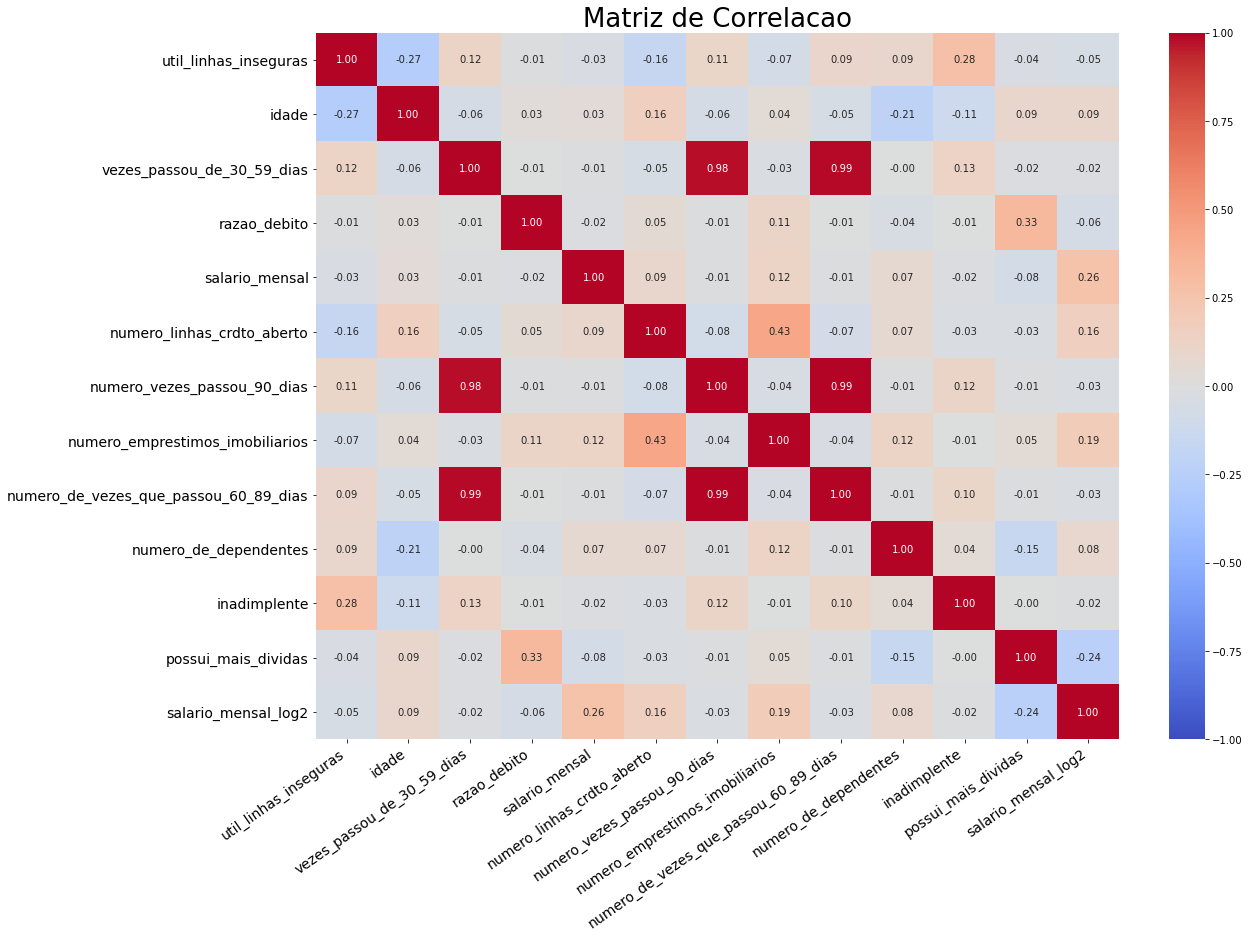

In [8]:
# Tamanho da figura
plt.figure(figsize = (18, 13))

# Criando o objeto referente ao plot
ax = sns.heatmap(df_corr, 
                 vmin = -1, 
                 cmap = 'coolwarm',
                 annot = True,
                 fmt='.2f')

ax.set_xticklabels(ax.get_xticklabels(), 
                   ha = 'right',
                   rotation = 35,
                   fontsize = 14)

ax.set_yticklabels(ax.get_yticklabels(), 
                   fontsize = 14)


# Titulo do Grafico
plt.title('Matriz de Correlacao' , 
          fontsize = 26)

# Mostrar Figura
plt.show()

Percebe-se uma correlacão quase perfeita entre as variaveis <b>'vezes_passou_de_30_59_dias', 'numero_vezes_passou_90_dias', 'numero_vezes_passou_60_89_dias'</b>, indicando que uma dessas variaves tera de ser removida do modelo.

### Acrescentando dados - SMOTE

#### Padronizacão dos dados

In [9]:
# 5 primeiros registros
df_train.tail(5)

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente,possui_mais_dividas,salario_mensal_log2
106584,0.137396,59,1,0.448912,9600.0,10,0,2,0,0.0,0,0,13.228819
106585,0.276964,46,0,0.491288,12224.0,19,0,4,0,4.0,0,0,13.577429
106586,0.181257,43,0,0.382635,12000.0,13,0,2,0,2.0,0,0,13.550747
106587,0.037699,86,0,0.248107,7000.0,14,0,2,0,1.0,0,0,12.773139
106588,1.000000,57,0,0.002352,3825.0,1,0,0,0,0.0,0,0,11.901244


É perceptivel que temos valores em escala bem discrepante como a idade, credito em aberto e salario mensal, sendo assim precisaremos aplicar uma normalizacão/ padronizacão dos dados. Aplicaremos o MinMaxScaler para esses registros

In [10]:
# Realizar padronizacão nas colunas cujo valor seja maior que 1.
to_scale = [col for col in df_train.columns if df_train[col].max() > 1]

mms = MinMaxScaler()

df_train_treated = df_train.copy()

df_scaled = mms.fit_transform(df_train[to_scale])
df_scaled = pd.DataFrame(df_scaled, 
                         columns = to_scale)

for col in df_scaled:
    df_train_treated[col] = df_scaled[col]

In [11]:
# Dataframe novo
df_train_treated.head(5)

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente,possui_mais_dividas,salario_mensal_log2
0,0.559518,0.279070,0.020408,2.435759e-06,0.003031,0.224138,0.000000,0.111111,0.0,0.10,1,0,0.611263
1,0.699027,0.220930,0.000000,3.696982e-07,0.000864,0.068966,0.000000,0.000000,0.0,0.05,0,0,0.527133
2,0.480683,0.197674,0.010204,2.581822e-07,0.001011,0.034483,0.010204,0.000000,0.0,0.00,0,0,0.537658
3,0.170756,0.104651,0.000000,1.093528e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00,0,0,0.543116
4,0.662576,0.325581,0.010204,7.560939e-08,0.021134,0.120690,0.000000,0.018519,0.0,0.00,0,0,0.741446


In [12]:
# Dataframe original
df_train.head(5)

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente,possui_mais_dividas,salario_mensal_log2
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1,0,13.154818
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0,11.344296
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0,0,11.570804
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0,11.688250
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0,0,15.956467


In [13]:
# Aplicando a padronizacão aos dados de teste
df_test_treated = df_test.copy()

df_scaled = mms.fit_transform(df_test[to_scale])
df_scaled = pd.DataFrame(df_scaled, 
                         columns = to_scale)

for col in df_scaled:
    df_test_treated[col] = df_scaled[col]

#### Aplicando o smote

In [14]:
sm = SMOTE(random_state=42)

X = df_train_treated.drop('inadimplente', axis=1)
y = df_train_treated['inadimplente']

X_balanced, Y_balanced = sm.fit_resample(X, y)

In [15]:
# Verificar os dados
X_balanced

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,possui_mais_dividas,salario_mensal_log2
0,0.559518,0.279070,0.020408,2.435759e-06,0.003031,0.224138,0.000000,0.111111,0.000000,0.100000,0,0.611263
1,0.699027,0.220930,0.000000,3.696982e-07,0.000864,0.068966,0.000000,0.000000,0.000000,0.050000,0,0.527133
2,0.480683,0.197674,0.010204,2.581822e-07,0.001011,0.034483,0.010204,0.000000,0.000000,0.000000,0,0.537658
3,0.170756,0.104651,0.000000,1.093528e-07,0.001097,0.086207,0.000000,0.000000,0.000000,0.000000,0,0.543116
4,0.662576,0.325581,0.010204,7.560939e-08,0.021134,0.120690,0.000000,0.018519,0.000000,0.000000,0,0.741446
...,...,...,...,...,...,...,...,...,...,...,...,...
199091,0.714007,0.371650,0.030807,8.882499e-07,0.002926,0.103120,0.030418,0.018519,0.010204,0.149047,0,0.608905
199092,0.729918,0.185352,0.010813,7.608122e-07,0.001416,0.052754,0.028784,0.000000,0.000000,0.050000,0,0.560230
199093,0.365001,0.383721,0.009582,1.037906e-06,0.001616,0.066865,0.000000,0.017390,0.000000,0.000000,0,0.568670
199094,0.415226,0.058140,0.000000,9.485429e-07,0.001670,0.155172,0.000000,0.004697,0.000000,0.037319,0,0.570245


In [16]:
# Classes balanceadas
Y_balanced.value_counts()

0    99548
1    99548
Name: inadimplente, dtype: int64

### Bases de Treino e Teste

In [17]:
# Selecionar as variaves
lst_var_reg = ['util_linhas_inseguras', 'idade', 'vezes_passou_de_30_59_dias',
               'razao_debito', 'salario_mensal', 'numero_linhas_crdto_aberto',
               'numero_emprestimos_imobiliarios', 'numero_de_dependentes',
               'possui_mais_dividas', 'salario_mensal_log2']

In [18]:
# Bases de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_balanced[lst_var_reg], 
                                                    Y_balanced, test_size = 0.3, random_state = 42)

### Submetendo os dados aos modelos

Os principais modelos que utilizaremos serão:
- Gaussian Naive Bayes
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting

In [19]:
def fn_calc_model_accuracy(p_y_train, 
                           p_y_test, 
                           p_y_pred_train, 
                           p_y_score_train, 
                           p_y_pred_test, 
                           p_y_score_test, 
                           model = 'Not Informed',
                           p_first_index = False):
    """
        Description:
            Function that calculates the accuracy of a model

        Keyword arguments:
            p_y_train -- Training base that corresponds to the dependent / target variable
            p_y_test -- Test base that corresponds to the dependent / target variable
            p_y_pred_train -- Object with the predicted value of the target variable, from the training base
            p_y_score_train -- Object with the estimated probabilities of the training base
            p_y_pred_test -- Object with the predicted value of the target variable, from the test base
            p_y_score_test -- Object with the estimated probabilities of the test base
            model(Defaul Value) -- Name of the model used in predictions

        Return:
            acc_train -- Accuracy of training base 
            gini_train -- Gini coefficient from training base 
            roc_auc_train -- Roc Cruve value from training base 
            acc_test --  Accuracy of test base 
            gini_test -- Gini coefficient from test base 
            roc_auc_test -- Roc Cruve value from test base 

        Exception:
            None
    """
    acc_train = round(accuracy_score(p_y_pred_train, p_y_train) * 100, 2)
    
    acc_test = round(accuracy_score(p_y_pred_test, p_y_test) * 100, 2)
    
    y_score_train = p_y_score_train[:, 1] if (p_first_index == False) else p_y_score_train
    y_score_teste = p_y_score_test[:, 1] if (p_first_index == False) else p_y_score_test
    
    fpr_train, tpr_train, thresholds = roc_curve(p_y_train, y_score_train)
    roc_auc_train = 100 * round(auc(fpr_train, tpr_train), 2)
    gini_train = 100 * round((2 * roc_auc_train/ 100 - 1), 2)

    # 
    fpr_test, tpr_test, thresholds = roc_curve(p_y_test, y_score_teste)
    roc_auc_test = 100 * round(auc(fpr_test, tpr_test), 2)
    gini_test = 100 * round((2 * roc_auc_test/100 - 1), 2)
    
    print('Model - ', model)
    print('----Taining Base----\nAccuracy: {} \nGini: {} \nROC Curve: {}'.format(acc_train, \
                                                                                     gini_train, \
                                                                                     roc_auc_train))

    print('\n----Test Base----\nAccuracy: {} \nGini: {} \nROC Curve: {}'.format(acc_test, \
                                                                                      gini_test, \
                                                                                      roc_auc_test))
    
    return acc_train, gini_train, roc_auc_train, acc_test, gini_test, roc_auc_test

In [20]:
def fn_confusion_matrix( p_conf_matrix, p_labels = None):
    """
        Description:
            Funcão que plota uma matriz de confusao

        Keyword arguments:
            p_conf_matrix -- Lista referente a matriz de confusao
            p_labels -- Labels da matriz

        Return:
            None
            
        Exception:
            None
    """
    plt.figure(figsize = (10, 8))

    ax = plt.subplot()

    sns.set(font_scale = 1.4)
    sns.heatmap(p_conf_matrix, 
                annot = True, 
                cmap = 'coolwarm',
                annot_kws={"size": 16},
                fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    
    if p_labels != None:
        ax.xaxis.set_ticklabels(p_labels)
        ax.yaxis.set_ticklabels(p_labels, rotation = 0)

    plt.show()

#### Gaussian Naive Bayes

In [21]:
# Instanciando o modelo e aplicando as bases de treino
gaussian_1 = GaussianNB()
gaussian_1.fit(X_train, y_train)

GaussianNB()

In [22]:
# Prevendo os dados
y_pred_gaussian_train = gaussian_1.predict(X_train)
y_score_gaussian_train = gaussian_1.predict_proba(X_train)

y_pred_gaussian_test = gaussian_1.predict(X_test)
y_score_gaussian_test = gaussian_1.predict_proba(X_test)

In [23]:
# Captar as principais metricas
_ ,_ , _ , acc_gaus, gini_gaus, roc_auc_gaus = \
fn_calc_model_accuracy(y_train, y_test, 
                       y_pred_gaussian_train, y_score_gaussian_train,
                       y_pred_gaussian_test, y_score_gaussian_test, 'Gaussian Model')

Model -  Gaussian Model
----Taining Base----
Accuracy: 71.48 
Gini: 54.0 
ROC Curve: 77.0

----Test Base----
Accuracy: 71.32 
Gini: 54.0 
ROC Curve: 77.0


In [24]:
cf = classification_report(y_test, y_pred_gaussian_test, target_names = ['Adimplente', 'Inadimplente'])
print(cf)

              precision    recall  f1-score   support

  Adimplente       0.72      0.69      0.70     29651
Inadimplente       0.71      0.74      0.72     30078

    accuracy                           0.71     59729
   macro avg       0.71      0.71      0.71     59729
weighted avg       0.71      0.71      0.71     59729



In [25]:
# Gerando a matriz
con_m_gauss = confusion_matrix(y_test, y_pred_gaussian_test)

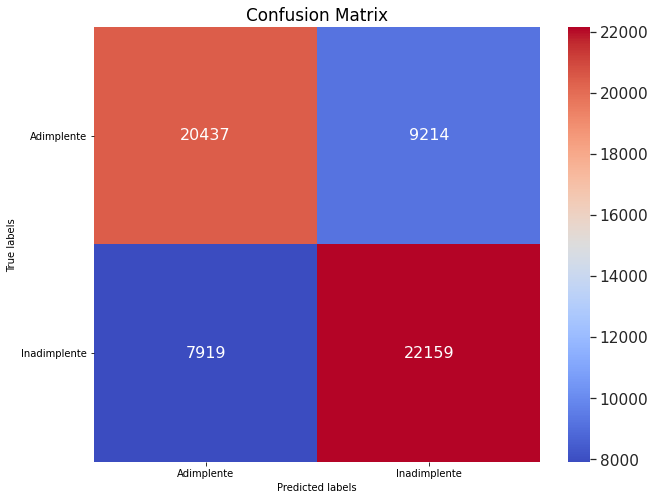

In [26]:
# Plotando a matriz
fn_confusion_matrix(con_m_gauss, ['Adimplente', 'Inadimplente'])

#### Logistic Regression

In [27]:
# Instanciando o modelo e aplicando as bases de treino
log_reg_1 = LogisticRegression(solver = 'liblinear')
log_reg_1.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [28]:
# Prevendo os dados de Teste
log_reg_pred = log_reg_1.predict(X_test)

In [29]:
# Prevendo os dados
y_pred_logreg_train = log_reg_1.predict(X_train)
y_score_logreg_train = log_reg_1.predict_proba(X_train)

y_pred_logreg_test = log_reg_1.predict(X_test)
y_score_logreg_test = log_reg_1.predict_proba(X_test)

In [30]:
# Captar as principais metricas
_ ,_ , _ , acc_logreg, gini_logreg, roc_auc_logreg = \
fn_calc_model_accuracy(y_train, y_test, 
                       y_pred_logreg_train, y_score_logreg_train,
                       y_pred_logreg_test, y_score_logreg_test, 'Logistic Regression')

Model -  Logistic Regression
----Taining Base----
Accuracy: 74.11 
Gini: 62.0 
ROC Curve: 81.0

----Test Base----
Accuracy: 73.88 
Gini: 62.0 
ROC Curve: 81.0


In [31]:
cf = classification_report(y_test, y_pred_logreg_test, target_names = ['Adimplente', 'Inadimplente'])
print(cf)

              precision    recall  f1-score   support

  Adimplente       0.73      0.75      0.74     29651
Inadimplente       0.75      0.73      0.74     30078

    accuracy                           0.74     59729
   macro avg       0.74      0.74      0.74     59729
weighted avg       0.74      0.74      0.74     59729



In [32]:
# Gerando a matriz
con_m_logreg = confusion_matrix(y_test, y_pred_logreg_test)

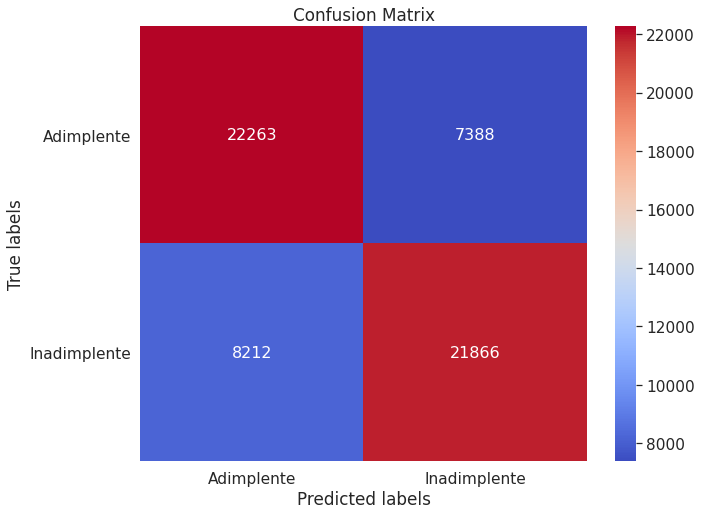

In [33]:
# Plotando a matriz
fn_confusion_matrix(con_m_logreg, ['Adimplente', 'Inadimplente'])

#### Decision Tree

In [34]:
# Instanciando o modelo e aplicando as bases de treino
dectree_1 = DecisionTreeClassifier(criterion = 'entropy',
                                     max_depth = 5, #--7
                                     random_state = 42)
dectree_1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [35]:
# Prevendo os dados de Teste
dectree_pred = dectree_1.predict(X_test)

In [36]:
# Prevendo os dados
y_pred_dectree_train = dectree_1.predict(X_train)
y_score_dectree_train = dectree_1.predict_proba(X_train)

y_pred_dectree_test = dectree_1.predict(X_test)
y_score_dectree_test = dectree_1.predict_proba(X_test)

In [37]:
# Captar as principais metricas
_ ,_ , _ , acc_dectree, gini_dectree, roc_auc_dectree = \
fn_calc_model_accuracy(y_train, y_test, 
                       y_pred_dectree_train, y_score_dectree_train,
                       y_pred_dectree_test, y_score_dectree_test, 'Decision Tree')

Model -  Decision Tree
----Taining Base----
Accuracy: 85.66 
Gini: 86.0 
ROC Curve: 93.0

----Test Base----
Accuracy: 85.34 
Gini: 86.0 
ROC Curve: 93.0


In [38]:
cf = classification_report(y_test, y_pred_dectree_test, target_names = ['Adimplente', 'Inadimplente'])
print(cf)

              precision    recall  f1-score   support

  Adimplente       0.81      0.92      0.86     29651
Inadimplente       0.91      0.79      0.84     30078

    accuracy                           0.85     59729
   macro avg       0.86      0.85      0.85     59729
weighted avg       0.86      0.85      0.85     59729



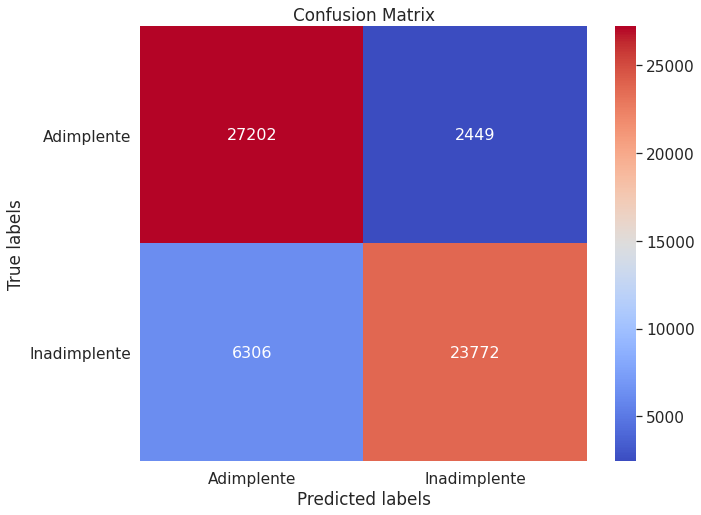

In [39]:
# Gerando a matriz
con_m_dectree = confusion_matrix(y_test, y_pred_dectree_test)

# Plotando a matriz
fn_confusion_matrix(con_m_dectree, ['Adimplente', 'Inadimplente'])

In [40]:
# Objeto com os dados da arvore
dot_data = tree.export_graphviz(dectree_1, out_file = None, 
                                feature_names = lst_var_reg,  
                                class_names = ['Adimplente', 'Inadimplente'],
                                filled=True)

# Gerando um arquivo referente a arvore
graph = graphviz.Source(dot_data)
graph.format = "jpeg"
graph.render("tree_1")

'tree_1.jpeg'

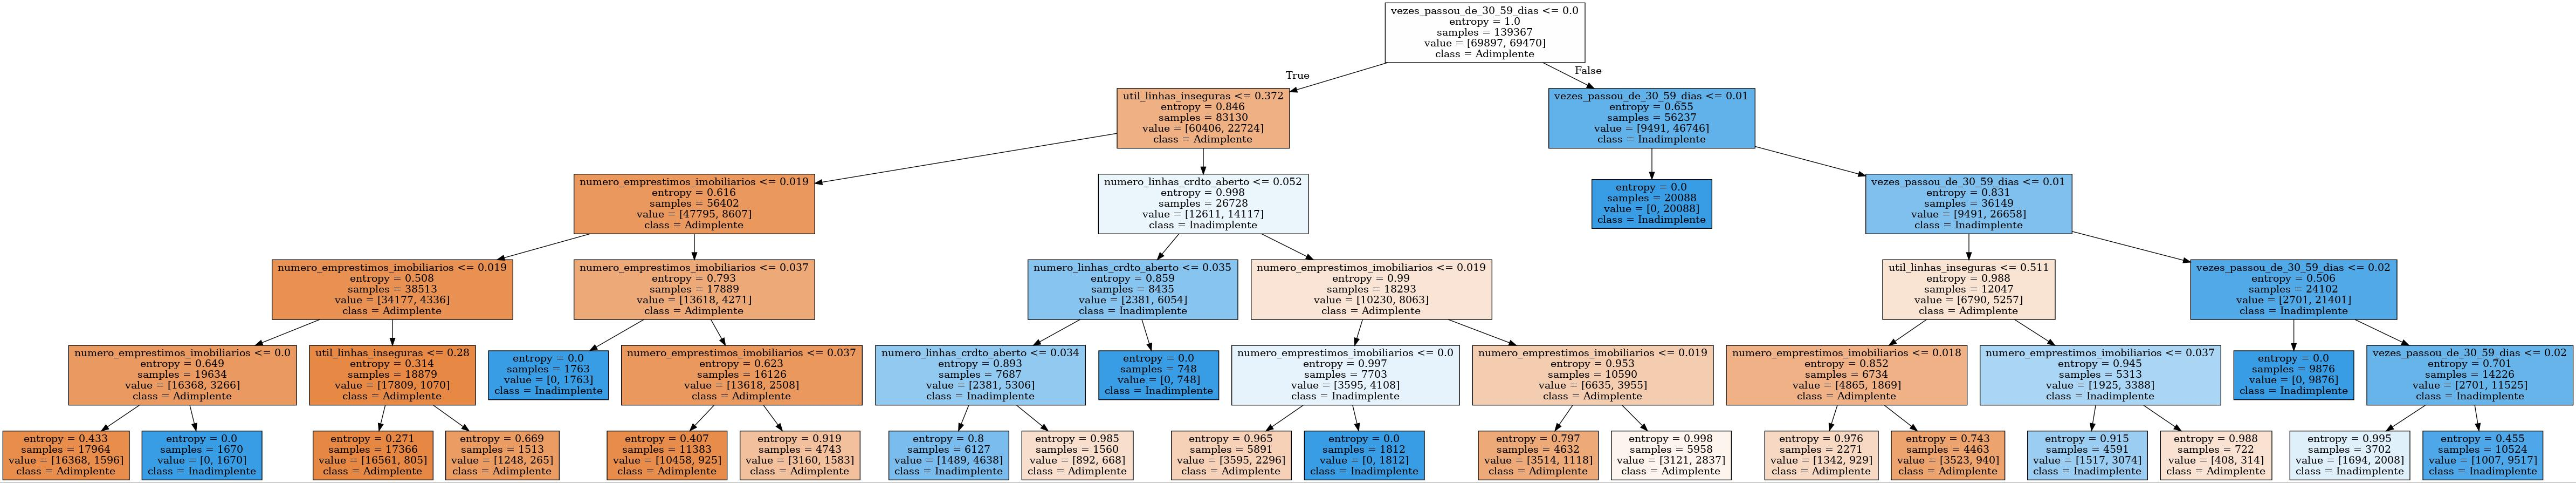

In [41]:
## Exibir a arvore
Image(filename='tree_1.jpeg') 

#### Random Forest

In [42]:
# Instanciando o modelo e aplicando as bases de treino
rndforest_1 = RandomForestClassifier(criterion = 'entropy',
                                     max_depth = 8,
                                     random_state = 43)
    
rndforest_1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, random_state=43)

In [43]:
# Prevendo os dados de Teste
rndforest_pred = rndforest_1.predict(X_test)

In [44]:
# Prevendo os dados
y_pred_rndforest_train = rndforest_1.predict(X_train)
y_score_rndforest_train = rndforest_1.predict_proba(X_train)

y_pred_rndforest_test = rndforest_1.predict(X_test)
y_score_rndforest_test = rndforest_1.predict_proba(X_test)

In [45]:
# Captar as principais metricas
_ ,_ , _ , acc_rndforest, gini_rndforest, roc_auc_rndforest = \
fn_calc_model_accuracy(y_train, y_test, 
                       y_pred_rndforest_train, y_score_rndforest_train,
                       y_pred_rndforest_test, y_score_rndforest_test, 'Random Forest')

Model -  Random Forest
----Taining Base----
Accuracy: 87.28 
Gini: 90.0 
ROC Curve: 95.0

----Test Base----
Accuracy: 86.84 
Gini: 88.0 
ROC Curve: 94.0


In [46]:
cf = classification_report(y_test, y_pred_rndforest_test, target_names = ['Adimplente', 'Inadimplente'])
print(cf)

              precision    recall  f1-score   support

  Adimplente       0.85      0.89      0.87     29651
Inadimplente       0.88      0.85      0.87     30078

    accuracy                           0.87     59729
   macro avg       0.87      0.87      0.87     59729
weighted avg       0.87      0.87      0.87     59729



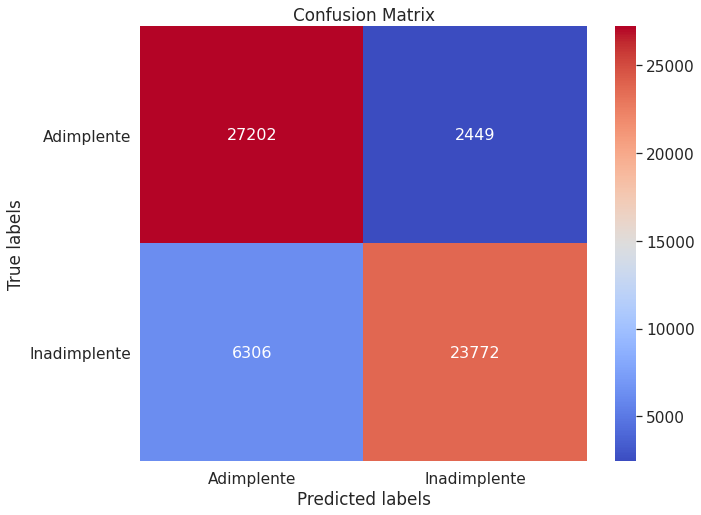

In [47]:
# Gerando a matriz
con_m_rndforest = confusion_matrix(y_test, y_pred_rndforest_test)

# Plotando a matriz
fn_confusion_matrix(con_m_dectree, ['Adimplente', 'Inadimplente'])

#### Gradient Boosted

In [48]:
# Instanciando o modelo e aplicando as bases de treino
gbc_1 = GradientBoostingClassifier(min_samples_leaf = 6)

gbc_1.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=6)

In [49]:
# Prevendo os dados de Teste
gradient_boosted_1 = gbc_1.predict(X_test)

In [50]:
# Prevendo os dados
y_pred_gbc_train = gbc_1.predict(X_train)
y_score_gbc_train = gbc_1.predict_proba(X_train)

y_pred_gbc_test = gbc_1.predict(X_test)
y_score_gbc_test = gbc_1.predict_proba(X_test)

In [51]:
# Captar as principais metricas
_ ,_ , _ , acc_gbc, gini_gbc, roc_auc_gbc = \
fn_calc_model_accuracy(y_train, y_test, 
                       y_pred_gbc_train, y_score_gbc_train,
                       y_pred_gbc_test, y_score_gbc_test, 'Decision Tree')

Model -  Decision Tree
----Taining Base----
Accuracy: 90.19 
Gini: 92.0 
ROC Curve: 96.0

----Test Base----
Accuracy: 89.86 
Gini: 92.0 
ROC Curve: 96.0


In [52]:
cf = classification_report(y_test, y_pred_gbc_test, target_names = ['Adimplente', 'Inadimplente'])
print(cf)

              precision    recall  f1-score   support

  Adimplente       0.88      0.93      0.90     29651
Inadimplente       0.92      0.87      0.90     30078

    accuracy                           0.90     59729
   macro avg       0.90      0.90      0.90     59729
weighted avg       0.90      0.90      0.90     59729



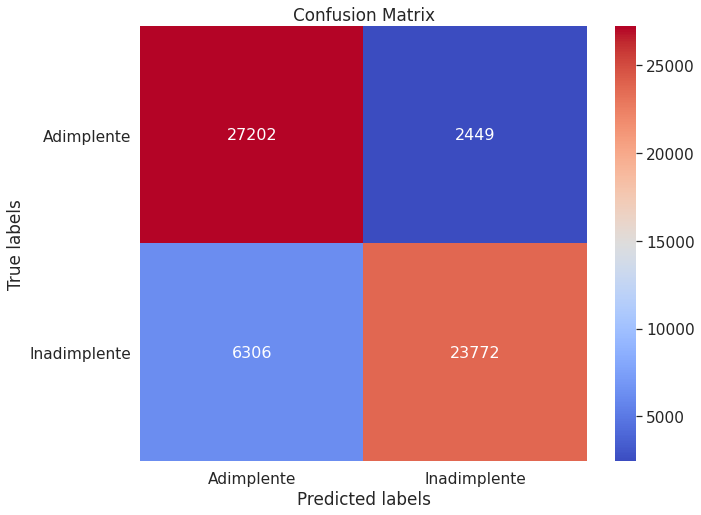

In [53]:
# Gerando a matriz
con_m_gbc = confusion_matrix(y_test, y_pred_gbc_test)

# Plotando a matriz
fn_confusion_matrix(con_m_dectree, ['Adimplente', 'Inadimplente'])

#### Comparando as metricas gerais dos modelos

In [54]:
models = pd.DataFrame({
    'Model': ['Decision Tree', 
               'Random Forest', 
               'Gradient Boosting',
               'Logistic Regression',
               'Gaussian Naive Bayes'],
    
     'Accuracy': [  acc_dectree,
                    acc_rndforest,
                    acc_gbc,
                    acc_logreg, 
                    acc_gaus],   
    
    
    'Gini': [       gini_dectree,
                    gini_rndforest,
                    gini_gbc,
                    gini_logreg,
                    gini_gaus],
    
    'Roc Curve':[   roc_auc_dectree,
                    roc_auc_rndforest,
                    roc_auc_gbc,
                    roc_auc_logreg,
                    roc_auc_gaus]

})
model_comp = models.sort_values(by = 'Accuracy', 
                                ascending = False)

model_comp = model_comp[['Model','Accuracy','Gini', 'Roc Curve']]
model_comp

,Model,Accuracy,Gini,Roc Curve
2,Gradient Boosting,89.86,92.0,96.0
1,Random Forest,86.84,88.0,94.0
0,Decision Tree,85.34,86.0,93.0
3,Logistic Regression,73.88,62.0,81.0
4,Gaussian Naive Bayes,71.32,54.0,77.0


O modelo que apresentou melhor score foi o <b>Gradiente Boosted</b>, com uma acurácia geral de 89,8 %, e com boa avuracia em todas as classes.

### Cross-Validation

O modelo em si teve boa performance e uma forma de prover maior acuracia e confiabilidade é aplicar também uma validacão cruzada.

Os modelos no qual subteremos à validacão cruzada serão o <b>Gradiente Boosted</b> e os algoritmos <b>Logistic Regression e Decicion Tree</b> que obtiveram boa performance, e possuem alta interpretabilidade além de serem menos custosos operacionalmente.

In [55]:
# Lista com a relacao de modelos no qual o dataset sera submetido
model_regressors = [LogisticRegression(solver = 'liblinear'),
                    DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 42),
                    GradientBoostingClassifier(min_samples_leaf = 6)]

# Percorrer cada modelo e realizar uma validacao cruzada
for model in model_regressors:
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 4)
    
    pipe = Pipeline(steps = [('regressor', model)])
    
    results = cross_validate(pipe, 
                             X = X_balanced[lst_var_reg],
                             y = Y_balanced,
                             cv = kfold)
    
    print("\nModelo {} \nMedia da Acuracia: {} ".format(model,results['test_score'].mean()))
    


Modelo LogisticRegression(solver='liblinear') 
Media da Acuracia: 0.7410646092957878 

Modelo DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42) 
Media da Acuracia: 0.8550598569274334 

Modelo GradientBoostingClassifier(min_samples_leaf=6) 
Media da Acuracia: 0.9005002448989765 


A validacao cruzada ratificou que o melhor modelo é o Gradient Boosted, contudo a Decision Tree teve uma acuracia apenas 5% inferior, o que nos leva a considerar que seria interessante aplicar um GridSearch para encontrar os melhores hiperparametros para essa variavel.

#### GridSearch no modelo Decision Tree

In [56]:
parameters = {'tree__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'tree__criterion': ['gini', 'entropy']}

# Pipeline com o modelo
model = Pipeline(steps=[
    ('tree', DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 42))
])

# Validacão Cruzada
kfold = KFold(n_splits = 5, shuffle = True, random_state = 4)

In [57]:
# Realizando o GridSearch dos dados
grid = GridSearchCV(model, 
                    param_grid = parameters, 
                    cv = kfold, 
                    n_jobs = -1, 
                    return_train_score = True)

In [58]:
# Submetendo os dados de Treino ao gridsearch
grid.fit(X = X_balanced[lst_var_reg], 
         y = Y_balanced)

%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [59]:
# Melhores hiperparametros
grid.best_params_

{'tree__criterion': 'gini', 'tree__max_depth': 10}

#### Validacão Cruzada com o Novo Modelo Decision Tree

In [60]:
# Lista com a relacao de modelos no qual o dataset sera submetido
model_regressors = [DecisionTreeClassifier(criterion = 'gini', max_depth = 10, random_state = 42)]

# Percorrer cada modelo e realizar uma validacao cruzada
for model in model_regressors:
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = 4)
    
    pipe = Pipeline(steps = [('regressor', model)])
    
    results = cross_validate(pipe, 
                             X = X_balanced[lst_var_reg],
                             y = Y_balanced,
                             cv = kfold)
    
    print("\nModelo {} \nMedia da Acuracia: {} ".format(model,results['test_score'].mean()))
    


Modelo DecisionTreeClassifier(max_depth=10, random_state=42) 
Media da Acuracia: 0.9002340442334814 


In [61]:
# Instanciando o modelo e aplicando as bases de treino
dectree_2 = DecisionTreeClassifier(criterion = 'gini',
                                     max_depth = 10, #--7
                                     random_state = 42)
dectree_2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [62]:
# Prevendo os dados de Teste
dectree_pred = dectree_2.predict(X_test)

In [63]:
# Prevendo os dados
y_pred_dectree_train = dectree_2.predict(X_train)
y_score_dectree_train = dectree_2.predict_proba(X_train)

y_pred_dectree_test = dectree_2.predict(X_test)
y_score_dectree_test = dectree_2.predict_proba(X_test)

In [64]:
# Captar as principais metricas
_ ,_ , _ , acc_dectree, gini_dectree, roc_auc_dectree = \
fn_calc_model_accuracy(y_train, y_test, 
                       y_pred_dectree_train, y_score_dectree_train,
                       y_pred_dectree_test, y_score_dectree_test, 'Decision Tree')

Model -  Decision Tree
----Taining Base----
Accuracy: 90.56 
Gini: 92.0 
ROC Curve: 96.0

----Test Base----
Accuracy: 89.84 
Gini: 92.0 
ROC Curve: 96.0


In [65]:
cf = classification_report(y_test, y_pred_dectree_test, target_names = ['Adimplente', 'Inadimplente'])
print(cf)

              precision    recall  f1-score   support

  Adimplente       0.87      0.93      0.90     29651
Inadimplente       0.93      0.87      0.90     30078

    accuracy                           0.90     59729
   macro avg       0.90      0.90      0.90     59729
weighted avg       0.90      0.90      0.90     59729



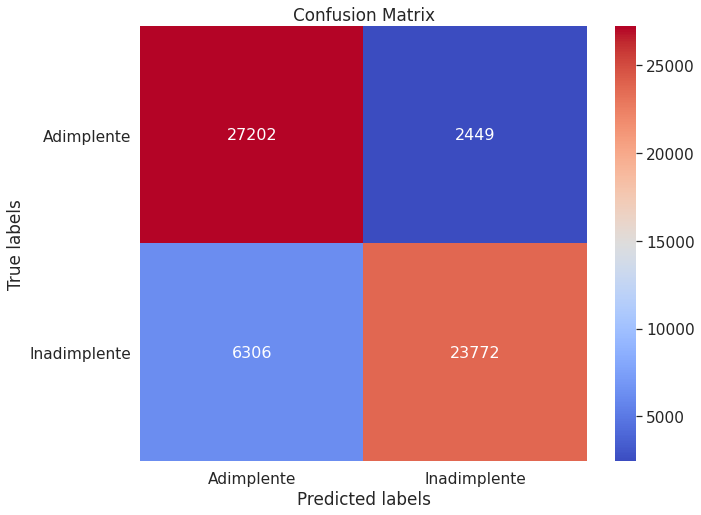

In [66]:
# Gerando a matriz
con_m_dectree2 = confusion_matrix(y_test, y_pred_dectree_test)

# Plotando a matriz
fn_confusion_matrix(con_m_dectree, ['Adimplente', 'Inadimplente'])

Pontos a destacar:
- A arvore de decisão obteve uma acuracia geral igual ao modelo Gradiente Boosted;
- A arvore teve uma eficacia nas classes muito boa, sendo no geral superior a 85%;
- A arvore é um modelo que demanda menos processamento, logo é mais interessante de ser implementado;
- O GradientBoosted não foi submetido ao gridsearch, logo ele também pode ter uma melhora;
- A arvore possui uma profundidade alta se comparado a sua versão anterior anterior


#### Variaveis mais importantes para o modelo

Verificar quais variaveis melhor explicam o modelo

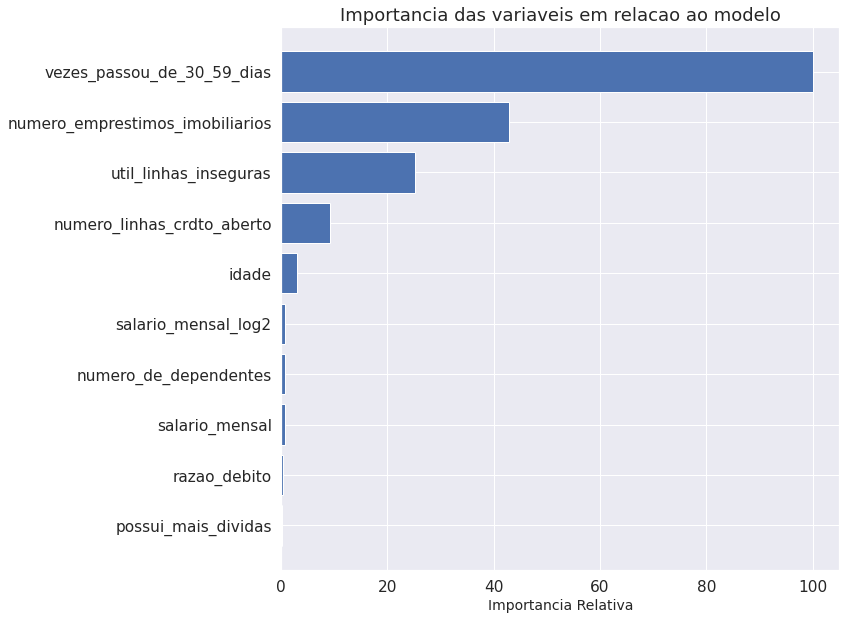

In [67]:
# Plotagem da importancia das variaveis

feature_importance = dectree_2.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 10))
ax = plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])


plt.xlabel('Importancia Relativa',
           fontsize = 14)

plt.title('Importancia das variaveis em relacao ao modelo',
          fontsize = 18)

plt.show()

In [68]:
# Variaveis mais importantes
lst_new_var = ['vezes_passou_de_30_59_dias', 'numero_emprestimos_imobiliarios', 'util_linhas_inseguras',
               'numero_linhas_crdto_aberto', 'idade']

In [69]:
# Bases de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_balanced[lst_new_var], 
                                                    Y_balanced, test_size = 0.3, random_state = 42)

In [70]:
# Instanciando o modelo e aplicando as bases de treino
dectree_3 = DecisionTreeClassifier(criterion = 'gini',
                                     max_depth = 10, #--7
                                     random_state = 42)
dectree_3.fit(X_train, y_train)

# Prevendo os dados
y_pred_dectree_train = dectree_3.predict(X_train)
y_score_dectree_train = dectree_3.predict_proba(X_train)

y_pred_dectree_test = dectree_3.predict(X_test)
y_score_dectree_test = dectree_3.predict_proba(X_test)

In [71]:
cf = classification_report(y_test, y_pred_dectree_test, target_names = ['Adimplente', 'Inadimplente'])
print(cf)

              precision    recall  f1-score   support

  Adimplente       0.87      0.94      0.90     29651
Inadimplente       0.93      0.86      0.90     30078

    accuracy                           0.90     59729
   macro avg       0.90      0.90      0.90     59729
weighted avg       0.90      0.90      0.90     59729



In [72]:
# Gerando a matriz
con_m_dectree3 = confusion_matrix(y_test, y_pred_dectree_test)
con_m_dectree3

array([[27751,  1900],
       [ 4137, 25941]])

A retirada de algumas variaveis não impactou severamente o modelo. Com isso temos um modelo que explica o problema levantado e é mais performático

### Submetendo os dados de teste a arvore de decisao

In [73]:
# Prevendo os dados de Teste
dectree_pred_test = dectree_3.predict(df_test_treated[lst_new_var])

In [74]:
# Carregando a base de teste original sem a colunas e tratamentos feitos
df_test_original = pd.read_csv('case_datarisk/teste.csv')

In [75]:
# Primeiras linhas 
df_test_original.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0


In [76]:
# Criando a nova coluna
df_test_original['inadimplente'] = dectree_pred_test

In [77]:
# Primeiras linhas
df_test_original.head()

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.025849,62,0,0.081775,8180.0,3,0,2,0,0.0,1
1,0.667083,55,0,0.153112,2200.0,3,0,0,0,0.0,0
2,0.007093,44,0,0.148800,7499.0,20,0,1,0,0.0,1
3,0.091213,54,0,0.351635,5900.0,15,0,1,1,0.0,1
4,0.112680,54,0,0.065959,2167.0,3,0,0,0,0.0,0


### Exportando os dados

In [79]:
# Exportando os dados
df_test_original.to_csv('resultado_final/teste.csv', index = False)